# Replication - Standard Case 2

Here we provide a notebook to replicate the simulation results for the standard case 2 simulation. 
As replicating all of the runs is rather time consuming, we provide this script to replicate a specified simulation run, which can then compared to the data provided on github.

The notebook replicates the results in:
- /out/simulation/sim_sc2

The main script can be found at: 
- /scripts/simulation/standard_case2.py


## Please choose the settup for replication:

In [1]:
run_id = 194 # any integer 1-200
batchsize = 64 # 64, 128, 256, 512, None(for full data set)

In [2]:
# google colab specific - installing probcox
!pip3 install torch==1.7.0
!pip3 install pyro-ppl==1.5.1
!pip3 install probcox

     |████████████████████████████████| 776.8MB 20kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 614kB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for probcox: filename=probcox-0.0.5-cp37-none-any.whl size=5226 sha256=948472f78d9d6f3103ee272d4615ead96b0ab13882f146190bfae9d38d784474
  Stored in directory: /root/.cache/pip/wheels/7a/ed/e5/71cb95c54c96702f1412114114806c74394f421b6cbda6af70
Successfully built probcox


In [3]:
# Modules
# =======================================================================================================================

import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(2456)
torch.manual_seed(6784)

In [4]:
# Simulation Settings
# =======================================================================================================================

I = 2000 # Number of Individuals
P_binary = 3
P_continuous = 3
P = P_binary + P_continuous
theta = np.asarray([0.8, -0.5, 0, -0.7, 1, 0])[:, None]
scale = 10  # Scaling factor for Baseline Hazard


In [5]:

# Simulation 
# =======================================================================================================================

# Class for simulation
TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

# Sample baseline hazard - scale is set to define censorship/events
TVC.make_lambda0(scale=scale)

# Sample Data 
np.random.seed(run_id)
torch.manual_seed(run_id)
surv = torch.zeros((0, 3))
X = torch.zeros((0, P))
for __ in (range(I)):
    a, b = TVC.sample()
    surv = torch.cat((surv, a))
    X = torch.cat((X, b))

total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()


In [6]:
# Inference Setup 
# =======================================================================================================================

# Custom linear predictor - Here: simple linear combination
def predictor(data):
    theta =  pyro.sample("theta", dist.Normal(loc=0, scale=1).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

def evaluate(surv, X, batchsize, sampling_proportion, iter_, predictor=predictor, run_id=run_id):
    sampling_proportion[1] = batchsize
    eta=5 # paramter for optimization 
    run = True # repeat initalization if NAN encounterd while training - gauge correct optimization settings
    while run:
        run = False
        pyro.clear_param_store()
        m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
        m.initialize(eta=eta, num_particles=5)
        loss=[0]
        for ii in tqdm.tqdm(range((iter_))):
            idx = np.unique(np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 2, replace=False), np.random.choice(range(surv.shape[0]), batchsize-2, replace=False)))) # random sample of data - force at least two events (no evaluation otherwise)
            data=[surv[idx], X[idx]] # subsampled data
            loss.append(m.infer(data=data))
            # divergence check
            if loss[-1] != loss[-1]:
                eta = eta * 0.1
                run=True
                break   
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
    return(out)

In [7]:
# Run
# =======================================================================================================================

if batchsize:
    pyro.clear_param_store()
    out = evaluate(batchsize=batchsize, iter_=15000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])
else:
    pyro.clear_param_store()
    out = evaluate(batchsize=total_obs, iter_=15000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])


100%|██████████| 15000/15000 [02:48<00:00, 89.05it/s]


In [8]:

# Download data from github
# =======================================================================================================================

if batchsize == None:
    batchsize='full'
#url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/probcox' + str(batchsize) +'_theta.txt?token=AIVIKKCD2HWYAHMGACO2MF3ATOU5C'
#url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/probcox' + str(batchsize) +'_theta_lower.txt?token=AIVIKKD3PBN5Z3LONO6G63TATOU5G'
#url3 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/probcox' + str(batchsize) +'_theta_upper.txt?token=AIVIKKARH2JYK4WUCPF5CR3ATOU5I'


url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/probcox' + str(batchsize) +'_theta.txt?token=AIVIKKFIDMQIFVQ76Y33XSLATPNN4'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/probcox' + str(batchsize) +'_theta_lower.txt?token=AIVIKKFYTLQ73RJT2O2WBADATPNN6'
url3 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/probcox' + str(batchsize) +'_theta_upper.txt?token=AIVIKKFJ5HKGLJFA6BWVTWTATPNOC'


theta_est_sim = pd.read_csv(url1, header=None, sep=';')
theta_est_lower_sim = pd.read_csv(url2, header=None, sep=';')
theta_est_upper_sim = pd.read_csv(url3, header=None, sep=';')




In [9]:
# Comparision
# =======================================================================================================================

print('Mean Absolute Error - estmiate: ', np.mean(np.abs(np.squeeze(out['theta'][1].detach().numpy()) - np.squeeze(np.asarray(theta_est_sim.iloc[np.where(theta_est_sim.iloc[:, 0] == run_id)[0], 1:-1])))))

print('Mean Absolute Error - lower bound estmiate: ',np.mean(np.abs(np.squeeze(out['theta'][0].detach().numpy()) - np.squeeze(np.asarray(theta_est_lower_sim.iloc[np.where(theta_est_lower_sim.iloc[:, 0] == run_id)[0], 1:-1])))))

print('Mean Absolute Error - upper bound estmiate: ',np.mean(np.abs(np.squeeze(out['theta'][2].detach().numpy()) - np.squeeze(np.asarray(theta_est_upper_sim.iloc[np.where(theta_est_upper_sim.iloc[:, 0] == run_id)[0], 1:-1])))))

Mean Absolute Error - estmiate:  3.7252902983462656e-08
Mean Absolute Error - lower bound estmiate:  9.934107499572539e-09
Mean Absolute Error - upper bound estmiate:  2.980232239694717e-08


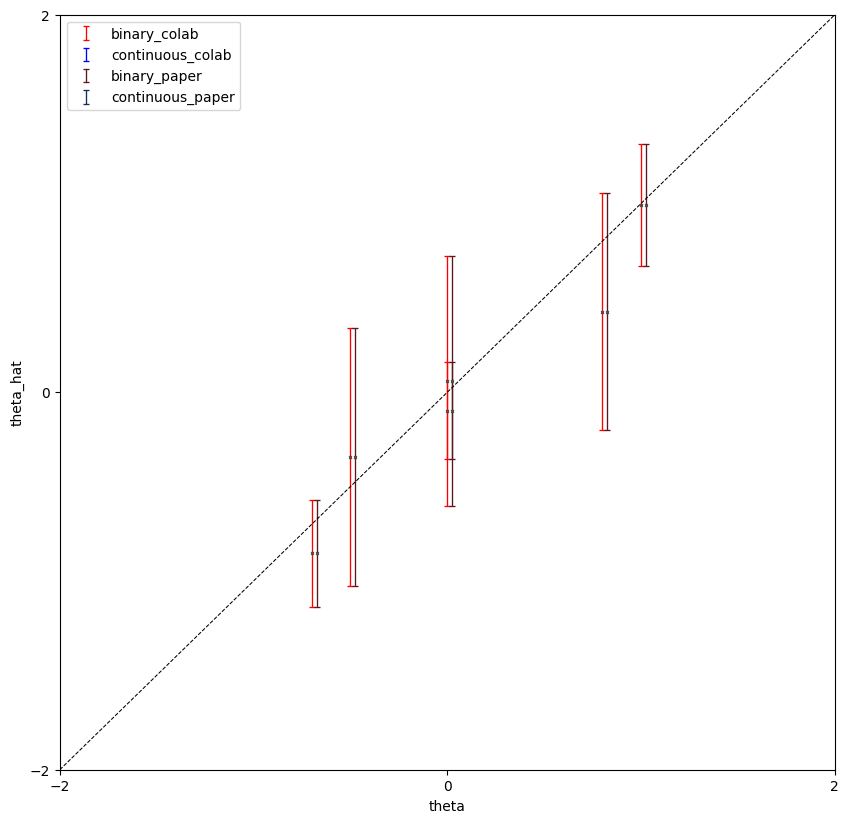

In [10]:
# Comparision - Plot
# =======================================================================================================================

theta_est_sim = np.squeeze(np.asarray(theta_est_sim.iloc[np.where(theta_est_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_lower_sim = np.squeeze(np.asarray(theta_est_lower_sim.iloc[np.where(theta_est_lower_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_upper_sim = np.squeeze(np.asarray(theta_est_upper_sim.iloc[np.where(theta_est_upper_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]

theta_est = out['theta'][1].detach().numpy()
theta_est_lower = out['theta'][0].detach().numpy()
theta_est_upper = out['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c="red", capsize=2, capthick=0.95, elinewidth=0.95, label='binary_colab')
ax.errorbar(theta[5000:, 0], theta_est[5000:, 0], yerr=(theta_est[5000:, 0] - theta_est_lower[5000:, 0], theta_est_upper[5000:, 0]- theta_est[5000:, 0]),  ls='', c="blue", capsize=2, capthick=0.95, elinewidth=0.95, label='continuous_colab')

ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.errorbar(theta[:, 0]+0.025, theta_est_sim[:, 0], yerr=(theta_est_sim[:, 0] - theta_est_lower_sim[:, 0], theta_est_upper_sim[:, 0]- theta_est_sim[:, 0]),  ls='', c="#5c161e", capsize=2, capthick=0.95, elinewidth=0.95, label='binary_paper')
ax.errorbar(theta[5000:, 0], theta_est_sim[5000:, 0], yerr=(theta_est_sim[5000:, 0] - theta_est_lower_sim[5000:, 0], theta_est_upper_sim[5000:, 0]- theta_est_sim[5000:, 0]),  ls='', c="#142e57", capsize=2, capthick=0.95, elinewidth=0.95, label='continuous_paper')
ax.plot(theta[:, 0]+0.025, theta_est_sim[:, 0], ls='', c=".3", marker='x', ms=2)

ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="black", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.legend()
plt.show()
plt.close()

# R evaluation

In [11]:
# prepare data frame to sent to R
rd = pd.DataFrame(np.concatenate((surv.numpy(), X.numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

In [12]:
# load R 
%load_ext rpy2.ipython

In [13]:
# install packages
%%R 
install.packages('survival')
install.packages('glmnet')

library(glmnet)
library(survival)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6274168 bytes (6.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [14]:
%%R -i rd -o r_coef -o r_se
m = coxph(Surv(V1, V2, V3) ~., data=rd)
r_coef = unname(m$coefficients)
r_se = unname(sqrt(diag(m$var)))


In [15]:

# Download data from github
# =======================================================================================================================
url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/R_theta.txt?token=AIVIKKFGIAY5I3ZK46MOYXDATOU5M'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_sc2/R_se.txt?token=AIVIKKCH4Z2NSTYKCNSACJTATOU5Q'

theta_R = pd.read_csv(url1, header=None, sep=';')
se_R = pd.read_csv(url2, header=None, sep=';')


In [16]:
# Comparision
# =======================================================================================================================

print('Error - estmiate: ', np.sum(np.abs(r_coef - np.squeeze(np.asarray(theta_R.iloc[np.where(theta_R.iloc[:, 0] == run_id)[0], 1:])))))

print('Error - se: ',np.sum(np.abs(r_se - np.squeeze(np.asarray(se_R.iloc[np.where(se_R.iloc[:, 0] == run_id)[0], 1:])))))


Error - estmiate:  8.309683094398501e-09
Error - se:  5.162570648753473e-10
